# Find the optimal arguments to condition the training set

Vary the arguments for conditioning the training set and see how they effect the frequency domain waveform

-On Window width

-Mean filter window

-Matching frequency interval

-fmax

In [1]:
%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [36]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window
import trainingseteob as traineob
import fisher

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)
imp.reload(traineob)
imp.reload(fisher)

import constants
imp.reload(constants)
from constants import *

In [4]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

from scipy import stats
import h5py
import glob

# Methods for the training set

In [5]:
def load_eob_training_set_td(orig_filename, mtot=2.0, distance=1.0):
    """Load a compressed waveform set and return a list of Waveform objects.
    """
    # Open original waveform file
    f = h5py.File(orig_filename)
    nwave = len(f['configurations'][:])
    print f.attrs['GenerationSettings']
    print f['configurations_keys'][:]
    print f['data_keys_name'][:]
    
    params = []
    hlist = []
    for i in range(nwave):
        print i, 
        try:
            p, h = traineob.get_waveform_from_training_set(f, i, mtot=mtot, distance=distance)
        except KeyError as e:
            print e
        else:
            # Run if an exception was not raised
            params.append(p)
            hlist.append(h)
        
    return np.array(params), hlist

# Load waveforms

In [6]:
#orig_filename = '../../data/TEOBv4_40hz/TEOB_data_train_corners_lhd.hdf5'
orig_filename = '../../data/TEOBv4_20hz/TEOB_data_train_corners_lhd.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 32768
        iota = 0
        f_min = 20
        distance = 1e+06

        Using lalsimulation version 1.7.3.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159


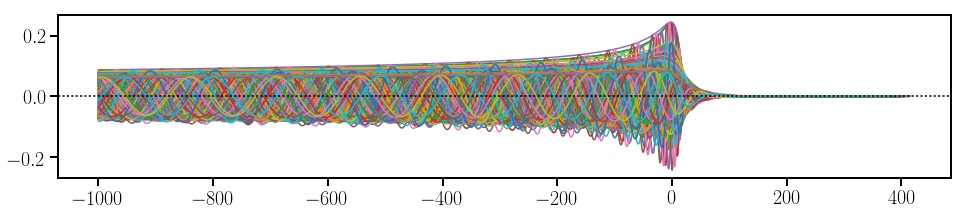

In [7]:
fig, ax = wave.plot_waveforms(hlist, hc=True, xi=-1000, npoints=10000)

In [8]:
# for i in range(len(hlist)):
#     p = params[i]
#     fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)

[  7.06036745e-01   3.42519685e-01  -2.75590551e-02   4.84251969e+03
   5.00000000e+03]


(-1000, 200)

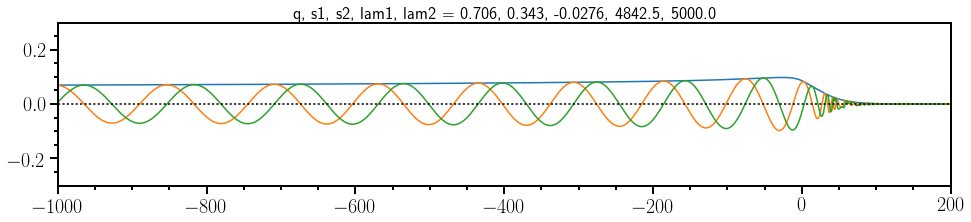

In [8]:
i=97
p = params[i]
print p
fig, ax = wave.plot_waveforms([hlist[i]], hc=True, xi=-1000, xf=200, npoints=10000)
title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
ax.set_title(title)
ax.minorticks_on()
ax.set_ylim(-0.3, 0.3)
ax.set_xlim(-1000, 200)

In [9]:
# There are some bad waveforms, so just remove them
badh_ind = [97]

params_clean = np.array([params[i] for i in range(len(params)) if i not in badh_ind])
hlist_clean = [hlist[i] for i in range(len(hlist)) if i not in badh_ind]

In [10]:
# for i in range(len(hlist_clean)):
#     p = params_clean[i]
#     fig, ax = wave.plot_waveforms([hlist_clean[i]], hc=True, xi=-1000, xf=200, npoints=10000)
#     title = '{}, {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(i, p[0], p[1], p[2], p[3], p[4])
#     ax.set_title(title)
#     ax.minorticks_on()
#     ax.set_ylim(-0.3, 0.3)

## Compare moving average filtering

In [107]:
# Fixed properties of the training set waveforms
mtot = 2.0
flow = 20.0

#i = 28
i = 0
h = hlist_clean[i]
params = params_clean[i]

# Start windowing at very beginning of waveform
winon_i = f_to_mf(flow, mtot)
winon_f = 0.00021

# Length of the zero padded time-domain waveform
delta_t = 5.0
min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)

# Filter with a moving average filter
filter_dfbyf_amp = 0.1
filter_dfbyf_phase = 0.05

# Fit the phase at the beginning using an interval just big enough to not cause numerical noise
fit_i = winon_f
fit_f = fit_i*(1.0+0.05)

# Truncation frequencies
trunc_i = winon_f
trunc_f = 0.07


npoints = 10000
win = 'planck'

print winon_i
print [mf_to_f(mf, mtot) for mf in [winon_i, winon_f, fit_i, fit_f, trunc_i, trunc_f]]

0.000197019641022
[20.0, 21.317671569285263, 21.317671569285263, 22.383555147749526, 21.317671569285263, 7105.890523095088]


In [108]:
filter_dfbyf_amp = None
filter_dfbyf_phase = None

h_1, hf2_1, dh_1 = traineob.condition_eob_waveform(
    h, params, delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f, 
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=False)

In [113]:
#filter_dfbyf_amp = 0.1
filter_dfbyf_amp = 0.1
filter_dfbyf_phase = 0.05

h_2, hf2_2, dh_2 = traineob.condition_eob_waveform(
    h, params, delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f, 
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=False)

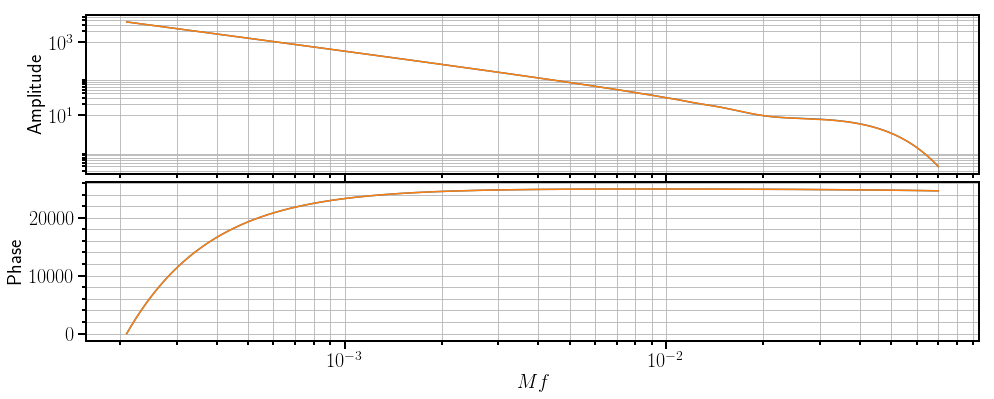

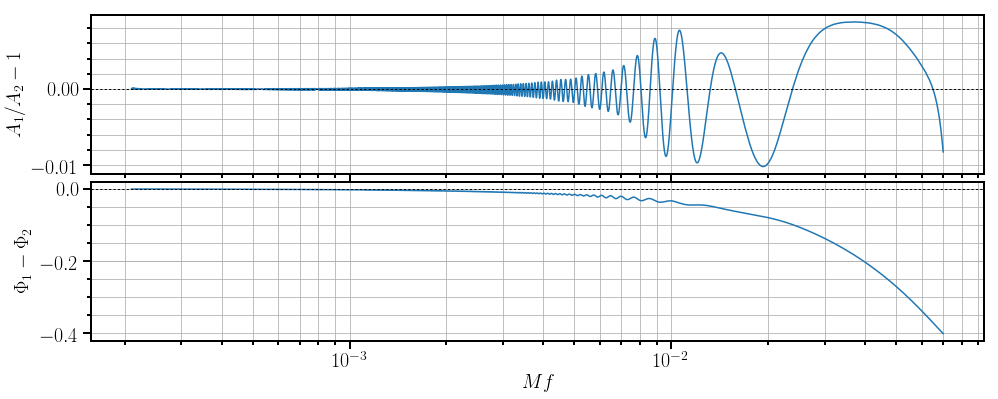

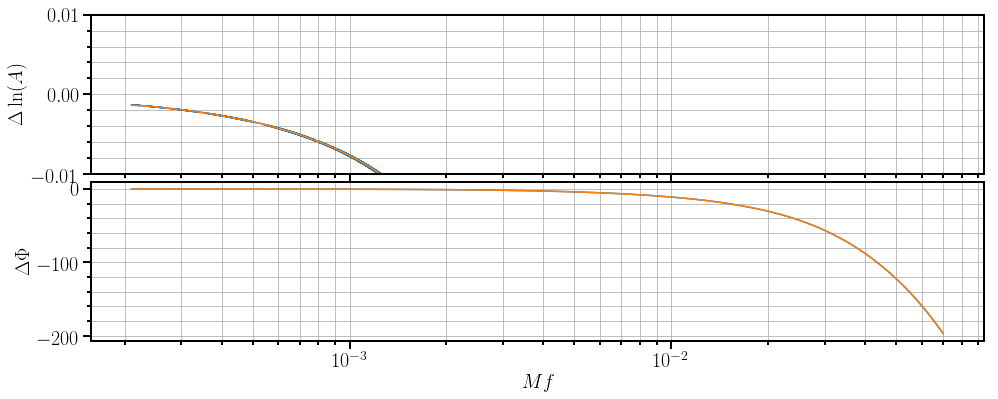

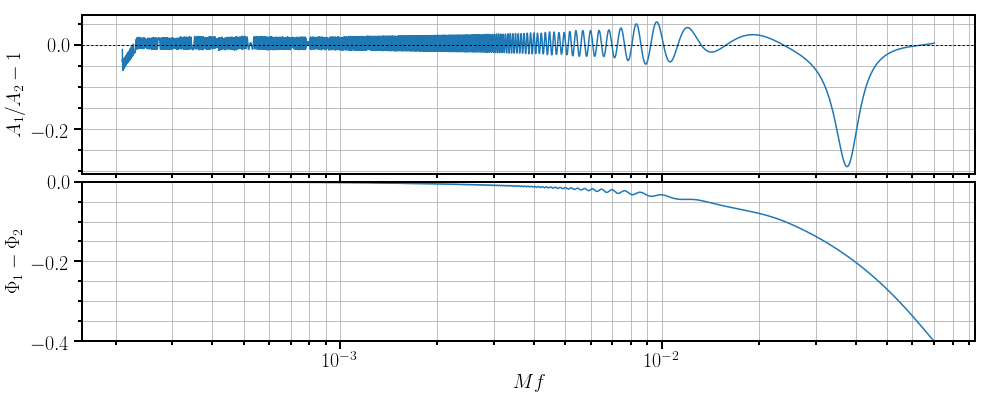

In [115]:
# fig, (ax1, ax2) = wave.plot_waveforms_fd([h_1, h_2, hf2_1])
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_1, h_2])
ax1.set_yscale('log')
#ax1.set_ylim(-0.05, 0.0)
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(h_1, h_2)
#ax1.set_ylim(-0.1, 0.1)
#ax2.set_ylim(-1, 1)
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_1, dh_2])
ax1.set_ylim(-0.01, 0.01)
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(dh_1, dh_2)
#ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.4, 0)
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

## Compare matching frequency choices

In [66]:
# Fixed properties of the training set waveforms
mtot = 2.0
flow = 20.0

#i = 28
i = 0
h = hlist_clean[i]
params = params_clean[i]

# Start windowing at very beginning of waveform
winon_i = f_to_mf(flow, mtot)
winon_f = 0.00021

# Length of the zero padded time-domain waveform
delta_t = 5.0
min_total_time = 4.0*train.zero_pn_coalescence_time(winon_i, 1.0)
n_ext = train.next_pow_2(min_total_time, delta_t)

# Filter with a moving average filter
filter_dfbyf_amp = 0.1
filter_dfbyf_phase = 0.05

# Fit the phase at the beginning using an interval just big enough to not cause numerical noise
fit_i = winon_f
fit_f = fit_i*(1.0+0.05)

# Truncation frequencies
trunc_i = winon_f
trunc_f = 0.07


npoints = 10000
win = 'planck'

print winon_i
print [mf_to_f(mf, mtot) for mf in [winon_i, winon_f, fit_i, fit_f, trunc_i, trunc_f]]

0.000197019641022
[20.0, 21.317671569285263, 21.317671569285263, 22.383555147749526, 21.317671569285263, 7105.890523095088]


In [64]:
fit_f = fit_i*(1.0+0.01)

h_1, hf2_1, dh_1 = traineob.condition_eob_waveform(
    h, params, delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f, 
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=False)

fit_f = fit_i*(1.0+0.05)
h_2, hf2_2, dh_2 = traineob.condition_eob_waveform(
    h, params, delta_t, n_ext,
    winon_i, winon_f,
    fit_i, fit_f, 
    trunc_i, trunc_f, npoints=npoints,
    win=win,
    filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
    plots=False)

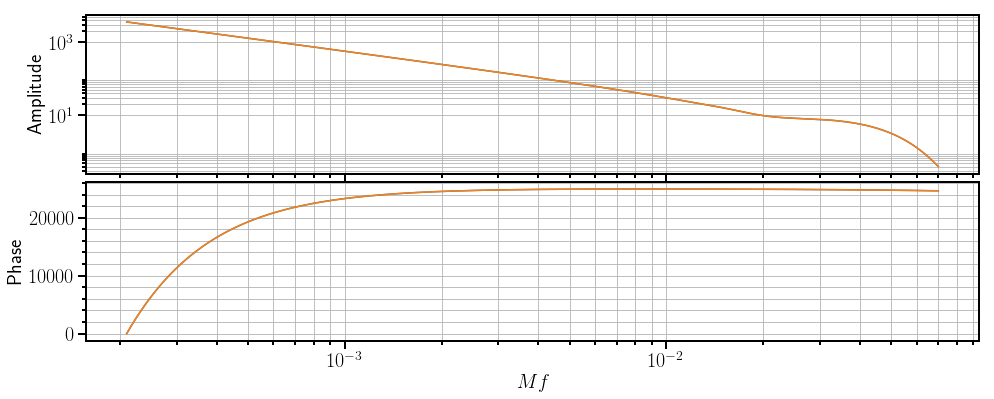

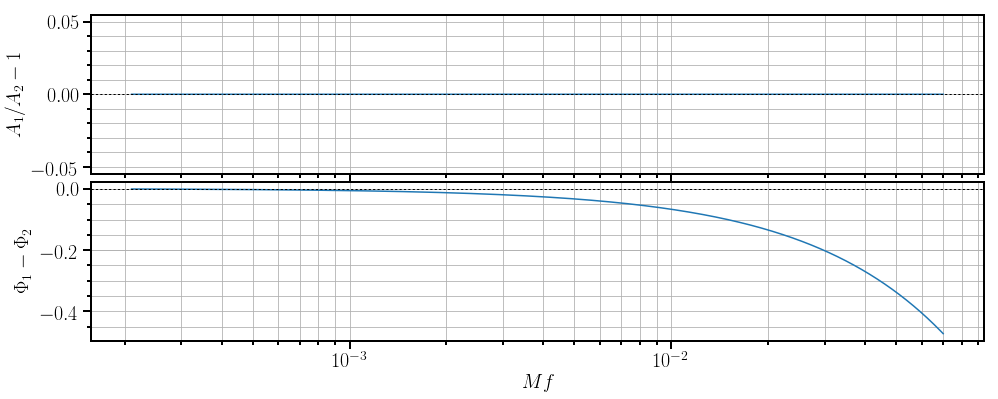

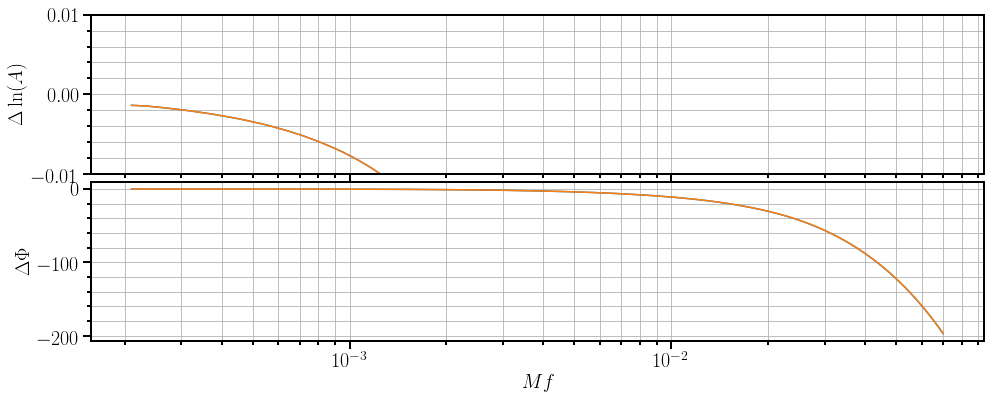

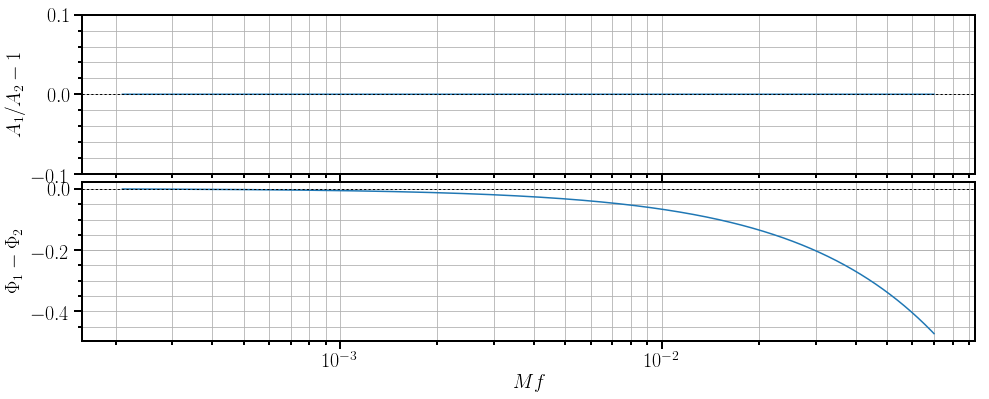

In [65]:
# fig, (ax1, ax2) = wave.plot_waveforms_fd([h_1, h_2, hf2_1])
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_1, h_2])
ax1.set_yscale('log')
#ax1.set_ylim(-0.05, 0.0)
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(h_1, h_2)
#ax1.set_ylim(-0.1, 0.1)
#ax2.set_ylim(-1, 1)
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

fig, (ax1, ax2) = wave.plot_waveforms_fd([dh_1, dh_2])
ax1.set_ylim(-0.01, 0.01)
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(dh_1, dh_2)
ax1.set_ylim(-0.1, 0.1)
#ax2.set_ylim(-1, 1)
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

In [94]:
dfs = np.logspace(np.log10(0.002), np.log10(0.5), 20)
fit_f_list = np.array([fit_i*(1.0+df) for df in dfs])

hs = []
hf2s = []
dhs = []
for i in range(len(fit_f_list)):
    df = dfs[i]
    fit_f = fit_f_list[i]
    print df, fit_i, fit_f
    
    h_1, hf2_1, dh_1 = traineob.condition_eob_waveform(
        h, params, delta_t, n_ext,
        winon_i, winon_f,
        fit_i, fit_f, 
        trunc_i, trunc_f, npoints=npoints,
        win=win,
        filter_dfbyf_amp=filter_dfbyf_amp, filter_dfbyf_phase=filter_dfbyf_phase,
        plots=False)
    
    hs.append(h_1)
    hf2s.append(hf2_1)
    dhs.append(dh_1)

0.002 0.00021 0.00021042
0.00267446774512 0.00021 0.000210561638226
0.00357638885984 0.00021 0.000210751041661
0.00478246832483 0.00021 0.000211004318348
0.00639527863841 0.00021 0.000211343008514
0.00855198321974 0.00021 0.000211795916476
0.011436001639 0.00021 0.000212401560344
0.0152926087583 0.00021 0.000213211447839
0.0204497944314 0.00021 0.000214294456831
0.0273461578006 0.00021 0.000215742693138
0.0365682084954 0.00021 0.000217679323784
0.0489002470588 0.00021 0.000220269051882
0.0653910667436 0.00021 0.000223732124016
0.0874431494124 0.00021 0.000228363061377
0.116931941318 0.00021 0.000234555707677
0.156365352714 0.00021 0.00024283672407
0.209097046144 0.00021 0.00025391037969
0.279611652756 0.00021 0.000268718447079
0.373906173228 0.00021 0.000288520296378
0.5 0.00021 0.000315


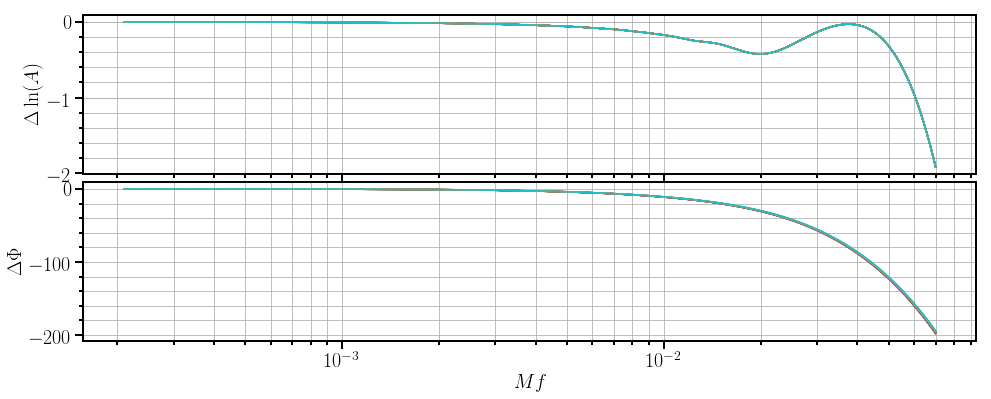

In [95]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(dhs)
#ax1.set_ylim(-0.01, 0.01)
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='both')
ax2.grid(which='both')

In [120]:
f = 0.05
dh_at_f = [dhs[i].interpolate('phase')(np.array([f]))[0] for i in range(len(dhs))]
print dh_at_f

[-120.83376947799822, -122.71652894028597, -122.87054601479004, -122.9856717072976, -122.56228453262302, -122.36803215447286, -122.24654655974796, -122.15411388701457, -122.11394462524568, -122.05381389212829, -122.00953370196579, -121.97248141780848, -121.91052891668275, -121.82010637270271, -121.70113915060155, -121.53438995961805, -121.29866398627388, -120.97873473369627, -120.55918009838604, -120.00467836937166]


(0, 0.0004)

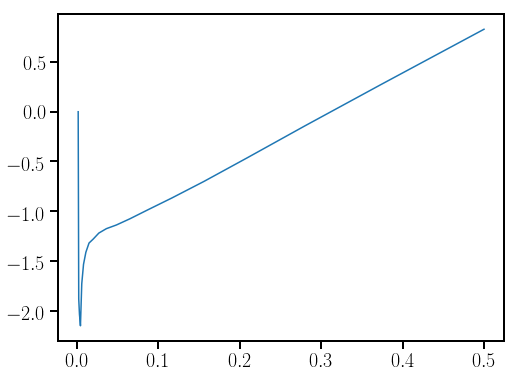

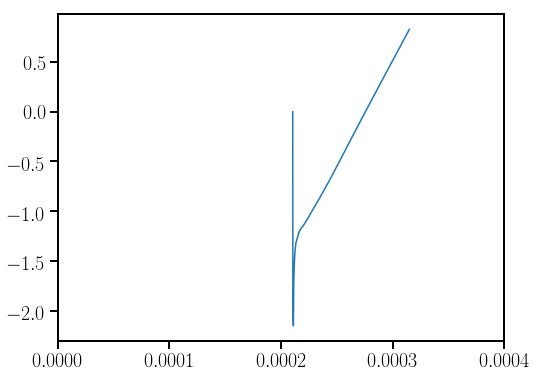

In [121]:
fig, axes = plt.subplots()
axes.plot(dfs, dh_at_f-dh_at_f[0])
#axes.set_xscale('log')

fig, axes = plt.subplots()
axes.plot(fit_f_list, dh_at_f-dh_at_f[0])
axes.set_xlim(0, 0.0004)
#axes.set_xscale('log')